In [2]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask, smaller_dtypes, make_df, hist2d_dask
import utils

import scipy.stats
import concurrent.futures
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask.distributed import progress
from dask import delayed
from yahist import Hist1D, Hist2D

In [3]:
set_plotting_style()

In [31]:
def make_df(fname, entrystart=None, entrystop=None, haslxy=True):
    t = uproot.open(fname)["Events"]
    branches = ["/n(DV|Jet|PV|PVM|Muon|GenMuon)$/","pass_*","nDV_*","nMuon_*",
                     "/BS_(x|y|z)$/",
                     "/Muon_n(Valid|Matched|Tracker|Expected).*/",
                     "/Muon_(pt|eta|phi|m|trackIso|charge|dz.*|dxy.*|chi2|ndof|drjet|pass*)$/",
                     "/DV_(chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|pass*)$/",
                     "run","luminosityBlock","event",
                     "PVM_x","PVM_y",
                     "dimuon_*","cosphi*","absdphi*","minabs*","logabs*",
                     "L1_*",
                    ]
    if haslxy: branches += ["lxy"]
    arrs = t.arrays(branches,outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    sel = slice(None,None)
#     sel = arrs["pass_baseline_iso"]
#     print(sel.shape)
#     print(arrs["pass_l1"].sum())

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","lxy","pass_","BS_","MET_","run","lumi","event","L1_",
                                        "dimuon","cosphi","absdphi","minabs","logabs"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("PVM_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    # augment
    df["Muon1_excesshits"] = df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits")
    df["Muon2_excesshits"] = df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")
    df["pass_excesshits"] = df.eval("DV_rhoCorr<3.5 or (Muon1_excesshits<=0 and Muon2_excesshits<=0)")
    df["excesshits"] = ~df["pass_excesshits"]
    
    for name,dtype in smaller_dtypes:
        if name not in df.columns: continue
        df[name] = df[name].astype(dtype, copy=False)
    return df


dfs = make_df("/home/users/namin/2019/scouting/repo/batch/output_synch_data2017.root")

In [32]:
dfs.columns

Index(['nDV', 'nJet', 'nPV', 'nPVM', 'nMuon', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_json', 'pass_fiducialgen', 'pass_excesshits',
       'pass_fiducialgen_norho', 'pass_baseline', 'pass_baseline_iso',
       'nDV_passid', 'nMuon_passid', 'nMuon_passiso', 'BS_x', 'BS_y', 'BS_z',
       'Muon1_nValidMuonHits', 'Muon2_nValidMuonHits', 'Muon1_nValidPixelHits',
       'Muon2_nValidPixelHits', 'Muon1_nMatchedStations',
       'Muon2_nMatchedStations', 'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_nExpectedPixelHits',
       'Muon2_nExpectedPixelHits', 'Muon1_pt', 'Muon2_pt', 'Muon1_eta',
       'Muon2_eta', 'Muon1_phi', 'Muon2_phi', 'Muon1_m', 'Muon2_m',
       'Muon1_trackIso', 'Muon2_trackIso', 'Muon1_chi2', 'Muon2_chi2',
       'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge', 'Muon2_charge', 'Muon1_dxy',
       'Muon2_dxy', 'Muon1_dz', 'Muon2_dz', 'Muon1_dxyError', 'Muon2_dxyError'

In [33]:
df = dfs.query("pass_baseline_iso")[[
    "event","luminosityBlock","run",
    "dimuon_mass",
    "DV_x","DV_y","DV_rhoCorr","lxy",
    "Muon1_pt","Muon1_eta","Muon2_pt","Muon2_eta",
    "absdphimumu","absdphimudv",
    "logabsetaphi","minabsdxy","excesshits",
    "dimuon_pt",
    "Muon1_dxyCorr",
    "Muon2_dxyCorr",
    "BS_x",
    "BS_y",
]].rename({"luminosityBlock":"lumi","dimuon_mass":"mass"},axis=1)
df

,event,lumi,run,mass,DV_x,DV_y,DV_rhoCorr,lxy,Muon1_pt,Muon1_eta,...,absdphimumu,absdphimudv,logabsetaphi,minabsdxy,excesshits,dimuon_pt,Muon1_dxyCorr,Muon2_dxyCorr,BS_x,BS_y
0,275917,1,302033,1.998553,0.041384,-0.118164,0.096444,0.096444,3.777374,-1.525164,...,0.336688,0.004872,0.085850,0.015514,False,7.365117,0.015514,-0.016804,0.084806,-0.031721
34,687055,1,302033,2.843703,0.102981,-0.026161,0.020191,0.020191,9.773147,-1.523873,...,0.134935,0.014000,0.498299,0.000518,False,13.819388,-0.000518,0.002202,0.084806,-0.031721
116,480897,1,302033,0.640107,0.147969,0.059884,0.111449,0.111449,5.198309,1.565082,...,0.026325,0.002915,0.690890,0.001330,False,9.214244,0.001604,-0.001330,0.084806,-0.031721
253,710535,1,302033,3.216196,-0.018537,0.285702,0.333688,0.333688,8.919423,-2.088893,...,0.434426,0.018529,-0.180813,0.052766,False,12.948071,-0.052766,0.090814,0.084806,-0.031721
343,201210,1,302033,4.552272,0.069833,-0.021640,0.017233,0.017233,9.594574,-1.496542,...,0.512283,0.007500,0.026388,0.002610,False,13.082446,-0.002610,0.006074,0.084806,-0.031721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400818,31613749,39,302033,1.213844,0.028984,0.033086,0.084975,0.084975,8.645239,0.849006,...,0.034781,0.014364,0.762413,0.000298,False,12.564462,-0.000298,-0.003253,0.084806,-0.031721
400896,31731494,39,302033,3.090746,0.144525,-0.168947,0.150051,0.150051,8.232279,1.198552,...,0.442521,0.011826,-0.058988,0.020758,False,11.358769,0.020758,-0.044879,0.084806,-0.031721
400969,31645079,39,302033,1.039077,-0.057135,0.165971,0.242937,0.242937,5.101951,1.226139,...,0.057302,0.015369,0.644476,0.005030,False,8.101517,-0.008889,0.005030,0.084806,-0.031721
400981,31732675,39,302033,0.975318,-0.135101,0.392547,0.477060,0.477060,4.291233,1.322381,...,0.196771,0.012982,-0.203064,0.038607,False,8.177569,0.038607,-0.055099,0.084806,-0.031721


In [34]:
fname = "~/public_html/dump/scouting/synchronization/data_2017D_v3.csv"
df.to_csv(fname,index=False)
!head -n 10 {fname}

event,lumi,run,mass,DV_x,DV_y,DV_rhoCorr,lxy,Muon1_pt,Muon1_eta,Muon2_pt,Muon2_eta,absdphimumu,absdphimudv,logabsetaphi,minabsdxy,excesshits,dimuon_pt,Muon1_dxyCorr,Muon2_dxyCorr,BS_x,BS_y
275917,1,302033,1.9985526,0.041384358,-0.11816368,0.09644354,0.09644354,3.777374,-1.5251638,3.6933384,-1.9354408,0.33668768,0.004871952,0.08584995,0.015513738,False,7.365117,0.015513738,-0.016803717,0.08480647,-0.031720918
687055,1,302033,2.8437028,0.10298109,-0.026160844,0.02019119,0.02019119,9.773147,-1.5238729,4.072396,-1.0988401,0.13493477,0.0139996605,0.49829853,0.0005179222,False,13.819388,-0.0005179222,0.0022021255,0.08480647,-0.031720918
480897,1,302033,0.6401072,0.14796874,0.059883773,0.11144908,0.11144908,5.1983094,1.5650822,4.0167193,1.435883,0.026325047,0.002914503,0.6908905,0.0013302102,False,9.214244,0.001603605,-0.0013302102,0.08480647,-0.031720918
710535,1,302033,3.2161956,-0.018537192,0.2857018,0.33368808,0.33368808,8.919423,-2.0888934,4.3009915,-2.3753788,0.43442595,0.018528976,-0.1

In [101]:
# dfr = pd.read_csv("/home/users/namin/2019/scouting/repo/analysis/synch/flat_dimuon_tree.csv",delimiter=";",skiprows=1)
# dfr = pd.read_csv("/home/users/namin/2019/scouting/repo/analysis/synch/flat_dimuon_tree_BScorr.csv",delimiter=";",skiprows=1)
dfr = pd.read_csv("/home/users/namin/2019/scouting/repo/analysis/synch/flat_dimuon_tree_synchtest.csv",delimiter=";",skiprows=1)
dfr

,run,lumi,event_num,dimuon_pt,dimuon_mass,lxy,dphidimudv,detadimudv,ctau,muon1_dxy,...,DVy,DVz,DVxerr,DVyerr,DVzerr,detamumu,dphimumu,dRmumu,dRmuon1jet,dRmuon2jet
0,302033,1,275917,7.365117,1.998552,0.096444,0.004872,-0.001451,0.026170,0.101965,...,-0.118164,-4.247911,0.012699,0.019945,0.053009,0.410277,-0.336688,0.530741,9999.000000,9999.000000
1,302033,1,83197,9.216790,1.985233,0.096557,-0.012416,0.030306,0.020796,-0.016992,...,-0.005232,-0.393791,0.015675,0.005213,0.022336,0.134798,-0.400191,0.422283,1.184223,0.801412
2,302033,1,687055,13.819388,2.843702,0.020191,-0.014000,0.157834,0.004154,-0.053929,...,-0.026161,-4.846591,0.011795,0.003948,0.022427,-0.425033,0.134935,0.445937,9999.000000,9999.000000
3,302033,1,635078,11.113295,3.091867,0.084002,-0.000511,-0.139982,0.023370,0.069541,...,-0.097875,-1.748858,0.007888,0.009317,0.015936,0.462744,-0.292367,0.547367,1.184637,0.696859
4,302033,1,682963,10.589152,1.063743,0.602467,-0.012240,0.101964,0.060517,-0.045646,...,0.484683,7.428332,0.012739,0.021309,0.049124,-0.196679,0.001950,0.196689,3.913443,3.784094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16450,302033,39,31645079,8.101517,1.039076,0.242937,0.015369,-0.684589,0.031155,-0.058353,...,0.165971,1.972620,0.015830,0.021570,0.046906,-0.252723,0.057302,0.259138,9999.000000,9999.000000
16451,302033,39,31943503,32.624800,2.251510,0.744169,-0.002125,-0.039582,0.051357,0.065227,...,-0.434606,-4.649322,0.025341,0.016291,0.026770,-0.160646,0.047414,0.167496,3.493458,9999.000000
16452,302033,39,31732675,8.177569,0.975317,0.477060,0.012982,-0.200139,0.056893,-0.026025,...,0.392547,-2.668715,0.012130,0.022654,0.047548,-0.123281,-0.196771,0.232201,9999.000000,9999.000000
16453,302033,39,31634649,23.901636,2.542862,0.163936,-0.003323,0.038363,0.017441,-0.013079,...,-0.084883,2.785637,0.019522,0.006758,0.007427,0.176601,0.167734,0.243563,2.608135,9999.000000


In [102]:
dfr.query("event_num == 429635")

,run,lumi,event_num,dimuon_pt,dimuon_mass,lxy,dphidimudv,detadimudv,ctau,muon1_dxy,...,DVy,DVz,DVxerr,DVyerr,DVzerr,detamumu,dphimumu,dRmumu,dRmuon1jet,dRmuon2jet
70,302033,1,429635,1.755999,10.52649,0.004257,-0.005673,0.705499,0.025517,-0.013222,...,-0.034564,-3.574937,0.004836,0.003678,0.005768,-0.777534,-2.785879,2.892349,9999.0,9999.0


In [36]:
dfr.columns

Index(['run', 'lumi', 'event_num', 'dimuon_pt', 'dimuon_mass', 'lxy',
       'dphidimudv', 'detadimudv', 'ctau', 'muon1_dxy', 'muon2_dxy',
       'muon1_dxycorr', 'muon2_dxycorr', 'muon1_trkiso', 'muon2_trkiso',
       'muon1_chi2overndof', 'muon2_chi2overndof', 'muon1_pt', 'muon2_pt',
       'muon1_eta', 'muon2_eta', 'muon1_phi', 'muon2_phi', 'DV_chi2overndof',
       'PVx', 'PVy', 'PVz', 'BSx', 'BSy', 'BSz', 'DVx', 'DVy', 'DVz', 'DVxerr',
       'DVyerr', 'DVzerr', 'detamumu', 'dphimumu', 'dRmumu', 'dRmuon1jet',
       'dRmuon2jet'],
      dtype='object')

In [37]:
# merged df
# all events in dfs with rutgers columns included
dfm = dfs.merge(dfr, how="left", left_on=["event"], right_on=["event_num"], suffixes=("_s","_r"))
dfm

,nDV,nJet,nPV,nPVM,nMuon,nGenMuon,pass_skim,pass_l1,pass_json,pass_fiducialgen,...,DVy,DVz,DVxerr,DVyerr,DVzerr,detamumu,dphimumu,dRmumu,dRmuon1jet,dRmuon2jet
0,1,0,0,1,2,0,True,True,True,True,...,-0.118164,-4.247911,0.012699,0.019945,0.053009,0.410277,-0.336688,0.530741,9999.000000,9999.0
1,1,0,0,2,2,0,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,0,7,2,0,True,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,9,1,2,0,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,15,1,2,0,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401110,1,2,15,4,2,0,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401111,1,0,0,2,3,0,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401112,1,1,0,2,2,0,True,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401113,1,1,9,3,2,0,True,True,True,True,...,-0.044328,-3.005666,0.016409,0.030638,0.092033,0.157888,0.077213,0.175757,2.420748,9999.0


In [38]:
dfm.columns.values

array(['nDV', 'nJet', 'nPV', 'nPVM', 'nMuon', 'nGenMuon', 'pass_skim',
       'pass_l1', 'pass_json', 'pass_fiducialgen', 'pass_excesshits',
       'pass_fiducialgen_norho', 'pass_baseline', 'pass_baseline_iso',
       'nDV_passid', 'nMuon_passid', 'nMuon_passiso', 'BS_x', 'BS_y',
       'BS_z', 'Muon1_nValidMuonHits', 'Muon2_nValidMuonHits',
       'Muon1_nValidPixelHits', 'Muon2_nValidPixelHits',
       'Muon1_nMatchedStations', 'Muon2_nMatchedStations',
       'Muon1_nTrackerLayersWithMeasurement',
       'Muon2_nTrackerLayersWithMeasurement', 'Muon1_nValidStripHits',
       'Muon2_nValidStripHits', 'Muon1_nExpectedPixelHits',
       'Muon2_nExpectedPixelHits', 'Muon1_pt', 'Muon2_pt', 'Muon1_eta',
       'Muon2_eta', 'Muon1_phi', 'Muon2_phi', 'Muon1_m', 'Muon2_m',
       'Muon1_trackIso', 'Muon2_trackIso', 'Muon1_chi2', 'Muon2_chi2',
       'Muon1_ndof', 'Muon2_ndof', 'Muon1_charge', 'Muon2_charge',
       'Muon1_dxy', 'Muon2_dxy', 'Muon1_dz', 'Muon2_dz', 'Muon1_dxyError',
       'M

In [39]:
dfm[["BS_x","BSx"]]

,BS_x,BSx
0,0.084806,0.084806
1,0.084806,NaN
2,0.084806,NaN
3,0.084806,NaN
4,0.084806,NaN
...,...,...
401110,0.084806,NaN
401111,0.084806,NaN
401112,0.084806,NaN
401113,0.084806,0.084806


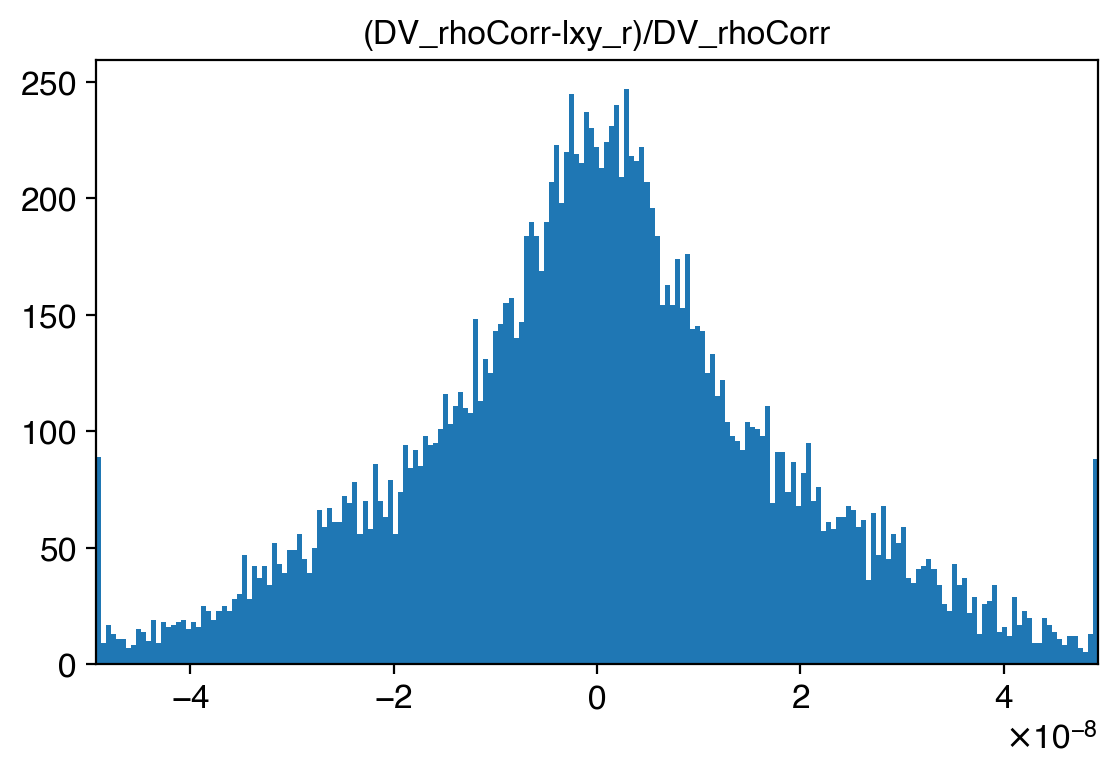

In [40]:
def compare(x,y):
    fracdiffs = (x-y) / x
    fig, ax = plt.subplots()
    low = fracdiffs.quantile(0.005)
    high = fracdiffs.quantile(0.995)
    h = Hist1D(fracdiffs, bins=np.linspace(low,high,200))
#     h = Hist1D(fracdiffs, bins=np.linspace(-0.0025,0.0025))
    h.plot(ax=ax)
    ax.set_title(f"({x.name}-{y.name})/{x.name}")
    
#     print(fracdiffs)
    
# dfm["lxy_test"] = dfm.eval("((DV_x-PVM_x)**2 + (DV_y-PVM_y)**2)**0.5")

# compare("lxy_s","lxy_r")
# compare("PVM_y","PVy")
# compare("DV_rhoCorr","lxy_r")
# compare(dfm[,"lxy_r")
# compare(dfm["Muon1_dxy"],dfm["muon1_dxy"])
# compare(dfm["Muon1_dxyCorr"],dfm["muon1_dxy"])

# compare(dfm["BS_x"],dfm["BSx"])
# compare(dfm["BS_y"],dfm["BSy"])
# compare(dfm["Muon1_dxyCorr"],dfm["muon1_dxycorr"])
compare(dfm["DV_rhoCorr"],dfm["lxy_r"])
# compare("DV_x","DVx")

In [80]:
dfr_temp = (dfr
 .query("muon1_trkiso < 0.1 and muon2_trkiso < 0.1")
 .query("muon1_chi2overndof < 3 and muon2_chi2overndof < 3")
 .query("DVxerr < 0.05 and DVyerr < 0.05 and DVzerr < 0.1")
 .query("DV_chi2overndof < 5")
 .query("abs(dphimumu) < 2.8")
 .query("abs(dphidimudv) < 0.02")
)
df = dfs[dfs["event"].isin(dfr_temp[~dfr_temp["event_num"].isin(dfs.query("pass_baseline_iso")["event"])]["event_num"])]

In [98]:
# df["pass_skim"].mean()
l1s = ["L1_DoubleMu4_SQ_OS_dR_Max1p2", "L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4","L1_DoubleMu_15_7"]
df[["run","luminosityBlock","event"]+l1s]

,run,luminosityBlock,event,L1_DoubleMu4p5_SQ_OS_dR_Max1p2,L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4,L1_DoubleMu_15_7
1606,302033,1,429635,False,False,False
1613,302033,1,541204,False,False,False
2669,302033,1,654811,False,False,False
2743,302033,1,107604,False,False,False
3062,302033,1,625619,True,True,False
...,...,...,...,...,...,...
394848,302033,38,31207403,False,False,False
396663,302033,39,31791831,False,False,False
396715,302033,39,31828620,False,False,False
398509,302033,39,31635099,False,False,False


In [95]:
# df.columns
# df["nMuon_passiso"].mean()
# df["nDV_passid"].mean()
# df."nDV_passid"].mean()
# df[["DV_xError","DV_yError","DV_zError","DV_chi2","DV_ndof"]]
# df.eval("DV_xError < 0.05").mean()
# dfr.eval("DVxerr<0.05").mean()
# dfr.eval("<0.05").mean()
# dfr.query("DVxerr>0.05")[["run","lumi","event_num","DVxerr","DVyerr","DVzerr"]]
# dfr.query("DVxerr")
dfr.columns
dfr_temp = (dfr
 .query("muon1_trkiso < 0.1 and muon2_trkiso < 0.1")
 .query("muon1_chi2overndof < 3 and muon2_chi2overndof < 3")
 .query("DVxerr < 0.05 and DVyerr < 0.05 and DVzerr < 0.1")
 .query("DV_chi2overndof < 5")
 .query("abs(dphimumu) < 2.8")
 .query("abs(dphidimudv) < 0.02")
)
dfr_temp.columns
# )["dphidimudv"].plot.hist(bins=100)

Index(['run', 'lumi', 'event_num', 'dimuon_pt', 'dimuon_mass', 'lxy',
       'dphidimudv', 'detadimudv', 'ctau', 'muon1_dxy', 'muon2_dxy',
       'muon1_dxycorr', 'muon2_dxycorr', 'muon1_trkiso', 'muon2_trkiso',
       'muon1_chi2overndof', 'muon2_chi2overndof', 'muon1_pt', 'muon2_pt',
       'muon1_eta', 'muon2_eta', 'muon1_phi', 'muon2_phi', 'DV_chi2overndof',
       'PVx', 'PVy', 'PVz', 'BSx', 'BSy', 'BSz', 'DVx', 'DVy', 'DVz', 'DVxerr',
       'DVyerr', 'DVzerr', 'detamumu', 'dphimumu', 'dRmumu', 'dRmuon1jet',
       'dRmuon2jet'],
      dtype='object')

In [4]:
# fname = "/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v10/output_1.root"
# dfmc = make_df(fname, haslxy=False)
# # df = dfmc

# # data
# df = dfs


In [5]:
# # bins = [np.linspace(-11,11,100),np.linspace(-1e-4,1e-4,100)]
# bins = [np.linspace(-3,3,100),np.linspace(-2e-3,2e-3,100)]

# # bins = [np.linspace(-11,11,100),np.linspace(0.01050,0.011,100)]

# # fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
# # fig, ax = plt.subplots(1,1,figsize=(4,4))
# fig, ax = plt.subplots()
# h = Hist2D(np.c_[
#     df["DV_x"],
#     (df["BS_x"]-df["PVM_x"])*1e0,
# #     (df["PVM_x"])*1e0,
#     ],bins=bins)
# # h.plot(ax=ax1, logz=True)
# h.plot(ax=ax, logz=True)

# # h = Hist2D(np.c_[
# #     df["DV_y"],
# #     (df["BS_y"]-df["PVM_y"])*1e0,
# #     ],bins=bins)
# # h.plot(ax=ax2, logz=True)

# ax.set_ylabel("BS_x - PV_x[0] (cm)")
# ax.set_xlabel("DV_x (cm)")

# # ax1.set_ylabel("BS_x - PV_x[0] (cm)")
# # ax2.set_ylabel("BS_y - PV_y[0] (cm)")
# # ax1.set_xlabel("DV_x (cm)")
# # ax2.set_xlabel("DV_y (cm)")

# fig.set_tight_layout(True)

In [8]:
client = Client("tcp://169.228.130.74:16623")
client

Client Scheduler: tcp://169.228.130.74:16623 Dashboard: http://169.228.130.74:13345/status,Cluster Workers: 70 Cores: 70 Memory: 280.00 GB


In [3]:
fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v11_unblind1fb_RAW_v11/*.root")
# fnames = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018*_v11_RAW_v11/*.root")
len(fnames)

29

In [4]:
# branches = ["dimuon_mass", "pass_*","logabsetaphi","DV_rhoCorr","DV_x","DV_y", "DV_z","PVM_x","PVM_y","PVM_z","BS_x","BS_y","BS_z","BS_*dz"]
branches = ["dimuon_mass", "pass_skim","pass_baseline*","logabsetaphi","DV_rhoCorr","DV_x","DV_y"]
# cut = "pass_baseline_iso"
cut = "pass_skim"
# cut = "pass_baseline"


In [25]:
ddf = make_df(
#     fnames[:50],
#     fnames,
    fnames[:2],
    branches = branches,
    cut = cut,
    chunksize = 1e6,
    persist = True,
#     partition_size="100MB",
    npartitions=len(fnames)//2,
#     partition_size="100MB",
    use_dask = True,
#     use_dask = False,
)

In [17]:
# ddf = ddf.repartition(npartitions=100).persist()
# ddf = ddf.repartition(partition_size="100MB").persist()

In [19]:
len(ddf)
# client.restart()

4984927

In [21]:
# 1e-6*ddf.memory_usage().sum().compute()
1e-6*ddf.memory_usage().sum()

114.653449

In [10]:
# df = dd.from_pandas(ddf.head(5), npartitions=1)
# df = ddf
df = ddf.query("logabsetaphi > 2")

bins = [np.linspace(-15,15,200),np.linspace(-15,15,200)]
# bins = [np.linspace(-0.2,0.2,200),np.linspace(-0.2,0.2,200)]
counts = hist2d_dask(df, "DV_x", "DV_y", bins=bins)
# counts = hist2d_dask(df, "DV_x", "DV_y", bins=bins)
counts = counts.compute().T
h = Hist2D.from_bincounts(counts, bins, errors=counts**0.5)

Text(0, 0.5, 'DV_y')

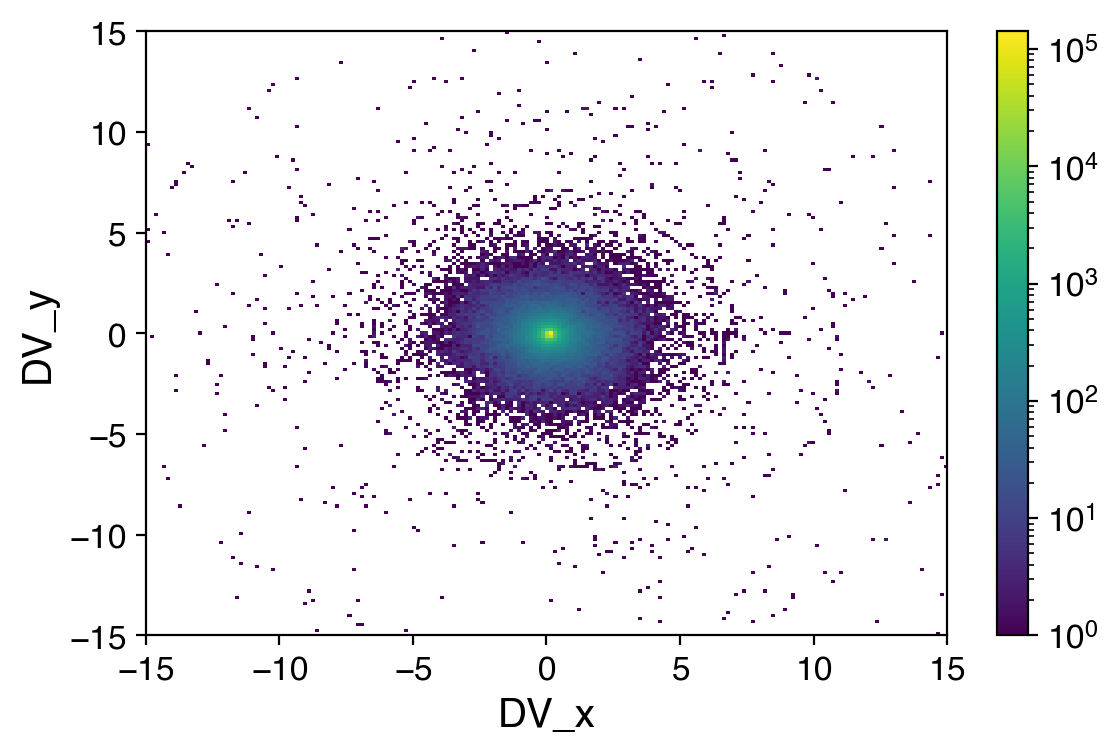

In [11]:
fig, ax = plt.subplots()
h.plot(ax=ax, logz=True)
# h.plot(ax=ax, cmap="binary")
ax.set_xlabel("DV_x")
ax.set_ylabel("DV_y")

In [12]:
bins = np.linspace(-6,6,100)
counts = da.histogram(ddf.eval("logabsetaphi"), bins=bins)[0].compute()
h = Hist1D.from_bincounts(counts, bins, errors=counts**0.5)

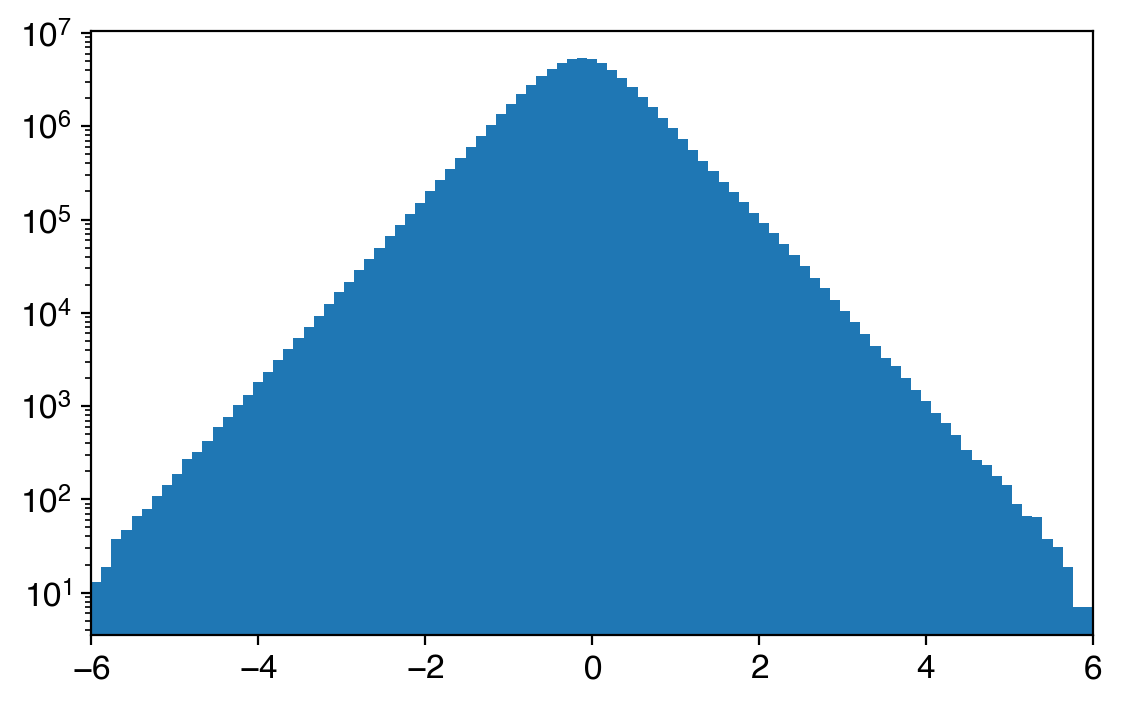

In [13]:
h.plot(log=True)

In [8]:
def make_df(
    path,
    branches = ["dimuon_mass", "pass_*"],
    cut = "pass_baseline_iso",
    chunksize = 500e3,
    xrootd = False,
    persist = True,
    client = None,
    func = None,
    partition_size = None,
    npartitions = None,
    use_dask = False,
):
    import dask.dataframe as dd
    from dask import delayed
    import uproot
    import pandas as pd
    from tqdm.auto import tqdm
    import concurrent.futures
    if isinstance(path, (str, bytes)):
        paths = uproot.tree._filename_explode(path)
    else:
        paths = [y for x in path for y in uproot.tree._filename_explode(x)]

    if not func:
        def func(fname, entrystart = None, entrystop = None):
            t = uproot.open(fname)["Events"]
            arrs = t.arrays(
                branches,
                outputtype = dict,
                namedecode = "ascii",
                entrystart = entrystart,
                entrystop = entrystop,
            )
            sel = slice(None,None)
            df = pd.DataFrame()
            for k in arrs.keys():
                if any(k.startswith(y) for y in ["n", "pass_", "BS_", "MET_","run", "lumi", "event", "L1_","dimuon", "cosphi", "absdphi","minabs", "logabs", "lxy"]):
                    df[k] = arrs[k][sel]
                if k.startswith("DV_"):
                    df[k] = arrs[k][sel][:,0]
                if k.startswith("PVM_"):
                    df[k] = arrs[k][sel][:,0]
                if k.startswith("Muon_"):
                    df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
                    df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]
            for name,dtype in smaller_dtypes:
                if name not in df.columns: continue
                df[name] = df[name].astype(dtype, copy=False)
            df = df.query(cut)
            return df

    if use_dask:
        chunks, total_events = get_chunking_dask(tuple(paths), chunksize, client=client, xrootd=xrootd)
    else:
        chunks, total_events = get_chunking(tuple(paths), chunksize, xrootd=xrootd)

    smallchunk_nevents = int(chunks[0][1] + (chunks[0][2]-chunks[0][1])//10)
    smallchunk = (chunks[0][0], chunks[0][1], smallchunk_nevents)
    meta = func(*smallchunk)
    
    if not use_dask:
        smallchunk_mb = meta.memory_usage().sum()/1e6
        estimated_mb = smallchunk_mb * total_events / smallchunk_nevents
        if estimated_mb > 15e3:
            raise RuntimeError("This dataframe would take approx. {:.1f}GB of RAM. Reduce the input size.".format(estimated_mb*1e-3))

        executor = concurrent.futures.ThreadPoolExecutor(6)
        futures = [executor.submit(func, *chunk) for chunk in chunks]
        ddf = pd.concat((future.result() for future in tqdm(futures)), sort=True)
        del executor
    else:
        delayed_func = delayed(func)
        ddf = dd.from_delayed((delayed_func(*chunk) for chunk in chunks), meta=meta)
        if partition_size:
            ddf = ddf.repartition(partition_size=partition_size)
        if npartitions:
            ddf = ddf.repartition(npartitions=npartitions)
        if persist:
            ddf = ddf.persist()
            
    return ddf


In [9]:
# fnames[0]
df = make_df(
#     fnames[1],
    fnames[:20],
    branches = branches,
    cut = "pass_baseline_iso",
)
df

,DV_rhoCorr,DV_x,DV_y,dimuon_mass,logabsetaphi,pass_baseline,pass_baseline_iso,pass_skim
30,0.280025,0.109835,-0.161349,3.521773,-0.335063,True,True,True
188,0.403646,0.119387,-0.284734,2.357998,-0.178866,True,True,True
754,0.827596,0.195013,-0.702460,0.639203,-0.923845,True,True,True
1245,0.320053,0.124803,-0.199683,1.033093,0.051146,True,True,True
2236,0.183818,0.098743,-0.064548,3.054973,-0.769103,True,True,True
...,...,...,...,...,...,...,...,...
106107,0.240251,-0.100267,0.074539,1.211226,-0.919368,True,True,True
106134,0.212717,-0.063094,-0.206729,3.209794,0.333974,True,True,True
106202,0.072960,0.122699,0.002505,3.049807,0.283130,True,True,True
106253,0.280157,0.348556,-0.182844,2.726043,-0.776320,True,True,True


In [10]:
df.memory_usage().sum()/1e6

26.101163

In [1]:
df.reset_index(drop=True)

NameError: name 'df' is not defined